In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Data loading and info

In [2]:
#Loads training data 
training = pd.read_csv('TrainOnMe.csv')

In [3]:
#Short look at the training data
training.head()

,id,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0,Bob,-0.78103,-0.63375,-0.03665,0.27517,False,F,-1.85755,0.22668,-2.35130,1.42092
1,1,Bob,0.42649,-0.50019,0.00696,0.11817,False,F,-1.73761,-1.61015,-5.12219,1.87723
2,2,Atsuto,1.86817,-0.45565,0.07658,0.09662,False,F,1.02798,-0.92326,-1.67111,2.07828
3,3,Atsuto,-1.80073,0.08535,-0.02467,0.14032,False,F,2.02793,-0.46318,2.41329,-0.62963
4,4,Bob,1.56943,-1.25860,-0.02092,0.22267,False,F,-0.43304,-1.99881,-1.58241,2.28423


Y is the target variable, and x1-x10 is the independant variables. x5 and x6 looks to be categorical, while the rest looks to be numerical values.

In [4]:
#Loads evaluation data
evaluation = pd.read_csv('EvaluateOnMe.csv')

In [5]:
evaluation.head()

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,1000,2.11820,0.30064,0.11441,0.08570,True,E,-0.23694,1.34755,4.41336,0.92271
1,1001,0.33456,-0.08190,-0.70144,0.69276,False,F,-0.97349,-1.46992,-3.30673,0.22554
2,1002,1.52200,-0.50104,-1.34160,1.28651,False,F,1.59231,1.96883,-1.36040,2.68363
3,1003,1.27021,1.24996,-0.14228,0.15172,True,A,-0.28572,-0.85520,-3.86445,0.86683
4,1004,-1.91738,0.83558,-0.88311,0.95150,False,A,0.74576,2.59335,-2.41387,1.01367


Same structure as the training data except that there is no label column which is what needs to be predicted. The output format should be a txt file with only the labels (same as in the training data) in the same order as in the evalutation data. 

In [6]:
#Information on training data 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1001 non-null   object 
 1   y       1001 non-null   object 
 2   x1      1001 non-null   object 
 3   x2      1000 non-null   object 
 4   x3      1000 non-null   float64
 5   x4      1000 non-null   float64
 6   x5      1000 non-null   object 
 7   x6      1000 non-null   object 
 8   x7      1000 non-null   float64
 9   x8      1000 non-null   float64
 10  x9      1000 non-null   float64
 11  x10     998 non-null    float64
dtypes: float64(6), object(6)
memory usage: 94.0+ KB


As we can see, x1 and x2 are Dtype 'object' and these we need to transfer to float64. Also x5 makes sense to transfer to boolean at some stage. 

In [7]:
#Information on evaluation data 
evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   x1          10000 non-null  float64
 2   x2          10000 non-null  float64
 3   x3          10000 non-null  float64
 4   x4          10000 non-null  float64
 5   x5          10000 non-null  bool   
 6   x6          10000 non-null  object 
 7   x7          10000 non-null  float64
 8   x8          10000 non-null  float64
 9   x9          10000 non-null  float64
 10  x10         10000 non-null  float64
dtypes: bool(1), float64(8), int64(1), object(1)
memory usage: 791.1+ KB


Dtypes here looks fine so no need to do any manipulations here.

# Data cleaning and preprocessing

In [8]:
training_v00 = training.copy()

## Null and odd values 

In [9]:
#Find columns with null values for evaluation data 
evaluation_null_columns = evaluation.columns[evaluation.isnull().any()]
evaluation[evaluation_null_columns].isnull().sum()

Series([], dtype: float64)

Luckily, the evaluation data set contains no null values

In [10]:
#Find columns with null values for training data 
null_columns = training.columns[training.isnull().any()]
training[null_columns].isnull().sum()

x2     1
x3     1
x4     1
x5     1
x6     1
x7     1
x8     1
x9     1
x10    3
dtype: int64

However, the training data does. Let's have a quick look at them.

In [11]:
#Gets all null columns 
training[training.isnull().any(axis=1)]

,id,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
210,210,Jörg,1.26306,-0.40346,-1.17480,1.25706,False,F,0.18570,0.91324,4.20330,NaN
405,405,Bob,2.19209,0.07498,-0.50459,0.62386,F,-0.46960,0.51974,-0.84861,0.76509,NaN
606,I said,ooh,I'm blinded by the lights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like we can drop these.

In [12]:
#Drop rows with NaNs
training = training.dropna()

Let's have a look at the values in the two categorical columns x5 and x6.

In [13]:
print(training['x5'].unique().tolist())
print(training['x6'].unique().tolist())

['False', 'True', '?']
['F', 'E', 'A', 'D', 'B', 'Fx', 'C']


In [14]:
training.loc[training['x5'] == '?']

,id,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
135,135,Bob,-0.52636,-0.26378,-0.09144,0.10429,?,F,-0.15787,0.19899,-2.71152,-0.12257
881,880,Atsuto,?,?,-0.98514,1.02721,?,A,2.50515,1.28566,2.53520,0.68691


Let's also remove the question-mark rows.

In [15]:
#Drop row w. '?' in x5
training.drop(training.loc[training['x5'] == '?'].index, inplace=True)

In [16]:
print(training['x5'].unique().tolist())
print(training['x6'].unique().tolist())

['False', 'True']
['F', 'E', 'A', 'D', 'B', 'Fx', 'C']


Now it looks fine.

## Dtypes manipulation

In [17]:
#Converts x1 and x2 into floats instead of objects
training[["x1", "x2"]] = training[["x1", "x2"]].apply(pd.to_numeric)

In [18]:
#Converts x5 into a boolean
training[["x5"]] = (training.x5=='True')

In [19]:
training

,id,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0,Bob,-0.78103,-0.63375,-0.03665,0.27517,False,F,-1.85755,0.22668,-2.35130,1.42092
1,1,Bob,0.42649,-0.50019,0.00696,0.11817,False,F,-1.73761,-1.61015,-5.12219,1.87723
2,2,Atsuto,1.86817,-0.45565,0.07658,0.09662,False,F,1.02798,-0.92326,-1.67111,2.07828
3,3,Atsuto,-1.80073,0.08535,-0.02467,0.14032,False,F,2.02793,-0.46318,2.41329,-0.62963
4,4,Bob,1.56943,-1.25860,-0.02092,0.22267,False,F,-0.43304,-1.99881,-1.58241,2.28423
...,...,...,...,...,...,...,...,...,...,...,...,...
996,995,Atsuto,1.44510,0.21567,-0.66888,0.78482,False,F,2.61427,0.36749,2.67405,2.16789
997,996,Bob,0.27265,0.06493,-0.20490,0.46078,False,F,-2.53548,-2.09720,-1.06034,1.31826
998,997,Jörg,0.35593,-0.46112,-1.15505,1.32716,False,F,1.86147,-0.48589,0.70206,0.99225
999,998,Atsuto,0.48402,1.44547,-0.26062,0.38700,True,A,0.01803,1.92690,3.28303,1.98225


In [20]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996 entries, 0 to 1000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      996 non-null    object 
 1   y       996 non-null    object 
 2   x1      996 non-null    float64
 3   x2      996 non-null    float64
 4   x3      996 non-null    float64
 5   x4      996 non-null    float64
 6   x5      996 non-null    bool   
 7   x6      996 non-null    object 
 8   x7      996 non-null    float64
 9   x8      996 non-null    float64
 10  x9      996 non-null    float64
 11  x10     996 non-null    float64
dtypes: bool(1), float64(8), object(3)
memory usage: 94.3+ KB


Now Dtype matches the evaluation data set. Next, let's change x5 and x6 into numerical values. 

In [21]:
# Training data: Replaces x5 and x6 into numerical values 
training['x5'] = training['x5'].replace({True:1,False:0})
training['x6'] = training['x6'].replace({'Fx':0, 'F':1, 'E':2, 'D':3, 'C':4, 'B':5, 'A':6})

The conversion needs to be done for the evaluation data as well

In [22]:
# Evaluation data: Replaces x5 and x6 into numerical values 
evaluation['x5'] = evaluation['x5'].replace({True:1,False:0})
evaluation['x6'] = evaluation['x6'].replace({'Fx':0, 'F':1, 'E':2, 'D':3, 'C':4, 'B':5, 'A':6})

## Remove outliers 

In [23]:
# Training data: Z-value 
z_training = np.abs(stats.zscore(training.iloc[:, 2:]))

In [24]:
# Training data: Nr. of outliers over 3,4,5 stds
traing_z_3 = np.where(z_training > 3)[0]
traing_z_4 = np.where(z_training > 4)[0]
traing_z_5 = np.where(z_training > 5)[0]

print(len(traing_z_3))
print(len(traing_z_4))
print(len(traing_z_5))

19
2
2


In [25]:
print(np.where(z_training > 4)[0])

[450 536]


In [26]:
np.where(z_training > 3)[0]

array([ 23,  51,  68, 127, 135, 271, 288, 305, 307, 329, 386, 450, 479,
       483, 509, 536, 577, 602, 961])

As we can see, only two outliners occurs outside the 4std, while 21 occur outsid 3 stds. Let's make two verison, where we drop entires outside 4std vs 3stds. 

In [27]:
training_v01 = training.copy()

In [28]:
# Removes entries with an outlier value above 4std
for entry_index in traing_z_4:
        training.drop(entry_index, inplace=True)

In [29]:
# Saves the '4stds' verison 
training_v02 = training.copy()

In [30]:
# Repeates for 3std
for entry_index in traing_z_3:
    if (entry_index!= 135): #Index doesn't exist
        training_v01.drop(entry_index, inplace=True)

In [31]:
# Saves the '3stds' verison 
training_v03 = training_v01.copy()

In [32]:
# Optionality of what version to use onwards
training = training_v02

Let's have a quick look at outliers for the evaluation data set.

In [33]:
# Evaluation data: Z-value 
z_evaluation = np.abs(stats.zscore(evaluation.iloc[:, 1:]))

In [34]:
# Evaluation data: Nr. of outliers over 3,4,5 stds
evaluation_z_3 = np.where(z_evaluation> 3)[0]
evaluation_z_4 = np.where(z_evaluation > 4)[0]
evaluation_z_5 = np.where(z_evaluation > 5)[0]

print(len(evaluation_z_3))
print(len(evaluation_z_4))
print(len(evaluation_z_5))

225
10
1


There are quite a lot more outliers for the evaluation data set. However, let's keep this as the assignment requires it.

## Data scaling

In [35]:
from sklearn import preprocessing

# gets the numerical columns
training_to_be_scaled = training.iloc[:, 2:]
evalaution_to_be_scaled = evaluation.iloc[:, 1:]

# build the scaler model 
mm_scaler = preprocessing.MinMaxScaler()

# fits using training data 
training_normalized = mm_scaler.fit_transform(training_to_be_scaled)

# transform the test data
evaluation_normalized = mm_scaler.transform(evalaution_to_be_scaled)

In [36]:
# replaces columns with new normalized data
training.iloc[:, 2:] = training_normalized
evaluation.iloc[:, 1:] = evaluation_normalized

In [37]:
training.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.523820,0.481054,0.549554,0.425941,0.311871,0.399564,0.993781,0.001016,0.456156,0.461207
std,0.139235,0.156797,0.215183,0.243859,0.463491,0.359732,0.031585,0.031718,0.150203,0.140564
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.421097,0.375868,0.401619,0.232265,0.000000,0.166667,0.993748,0.000007,0.354722,0.371087
50%,0.529301,0.477663,0.559414,0.409696,0.000000,0.166667,0.994489,0.000009,0.428034,0.459422
75%,0.618484,0.588579,0.720193,0.592912,1.000000,0.833333,0.995745,0.000012,0.524978,0.547551
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
evaluation.describe()

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5999.50000,0.520504,0.480157,0.539123,0.437695,0.302000,0.394050,0.994868,0.000010,0.453142,0.450136
std,2886.89568,0.144615,0.156131,0.220593,0.249852,0.459148,0.355240,0.001414,0.000005,0.151275,0.143116
min,1000.00000,0.000965,-0.175827,-0.049516,-0.005057,0.000000,0.000000,0.990733,-0.000002,-0.022730,-0.095565
25%,3499.75000,0.422937,0.376717,0.385426,0.239432,0.000000,0.166667,0.993786,0.000007,0.349768,0.358277
50%,5999.50000,0.520470,0.478218,0.551380,0.424861,0.000000,0.166667,0.994606,0.000009,0.426107,0.450516
75%,8499.25000,0.618472,0.584585,0.714029,0.603241,1.000000,0.666667,0.995850,0.000012,0.531968,0.542950
max,10999.00000,1.013341,1.044756,1.006999,1.025942,1.000000,1.000000,1.001246,0.000037,1.116798,1.053366


In [39]:
training

,id,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0,Bob,0.444311,0.379826,0.765631,0.235080,0.0,0.166667,0.993005,0.000011,0.354455,0.492029
1,1,Bob,0.566118,0.400527,0.788616,0.126758,0.0,0.166667,0.993124,0.000005,0.146140,0.542626
2,2,Atsuto,0.711546,0.407430,0.825309,0.111889,0.0,0.166667,0.995873,0.000007,0.405591,0.564919
3,3,Atsuto,0.341449,0.491282,0.771945,0.142040,0.0,0.166667,0.996867,0.000009,0.712655,0.264657
4,4,Bob,0.681411,0.282979,0.773922,0.198857,0.0,0.166667,0.994421,0.000004,0.412259,0.587755
...,...,...,...,...,...,...,...,...,...,...,...,...
996,995,Atsuto,0.668869,0.511480,0.432414,0.586713,0.0,0.166667,0.997450,0.000012,0.732258,0.574855
997,996,Bob,0.550599,0.488117,0.676955,0.363141,0.0,0.166667,0.992331,0.000004,0.451508,0.480645
998,997,Jörg,0.559000,0.406583,0.176177,0.960901,0.0,0.166667,0.996702,0.000009,0.584005,0.444496
999,998,Atsuto,0.571921,0.702091,0.647587,0.312237,1.0,1.000000,0.994869,0.000017,0.778041,0.554271


In [40]:
evaluation

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,1000,0.736767,0.524650,0.845247,0.104355,1.0,0.333333,0.994616,0.000015,0.863019,0.436785
1,1001,0.556845,0.465359,0.415253,0.523196,0.0,0.166667,0.993884,0.000006,0.282626,0.359481
2,1002,0.676626,0.400395,0.077856,0.932854,0.0,0.166667,0.996434,0.000017,0.428950,0.632042
3,1003,0.651227,0.671788,0.709959,0.149905,1.0,1.000000,0.994567,0.000008,0.240697,0.430589
4,1004,0.329682,0.607562,0.319504,0.701714,0.0,1.000000,0.995593,0.000019,0.349751,0.446871
...,...,...,...,...,...,...,...,...,...,...,...
9995,10995,0.343283,0.683538,0.779482,0.137597,1.0,1.000000,0.993421,0.000008,0.522527,0.517707
9996,10996,0.561572,0.403735,0.661992,0.208123,0.0,0.166667,0.994133,0.000001,0.432435,0.262286
9997,10997,0.515899,0.470168,0.297800,0.700865,0.0,0.166667,0.995066,0.000013,0.837564,0.673553
9998,10998,0.430651,0.513692,-0.010183,1.000876,0.0,0.166667,0.993483,0.000012,0.583407,0.610083


# Dimensionality reduction

## Feature elimination: 
Reduce the feature space by eliminating features

In [41]:
# generating the correlation matrix
corr = training.iloc[:, 2:].corr()

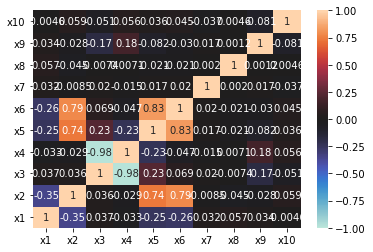

In [42]:
# generating the correlation heat-map
ax = sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, center = 0)
plt.yticks(rotation = 0)
ax.invert_yaxis()
plt.show()

As seen in above correlation heatmap, some features have a high correlation which can be beneficial to remove to avoid “Multicollinearity” (When one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This can lead to skewed or misleading results.)

x3 and x4 have a strong negative correlation - let's remove the latter. 

x5 and X6 have a strongly positive correlation - let's remove the first(x5 likely to be passed or failed, while x6 is the grading).

x5 and x6, both have a high correlation with x2 as well - let's remove x2. 

Same procedure for training and evaluation data set. 

In [43]:
training_feature_v00 = training.copy()
evaluation_feature_v00 = evaluation.copy()

In [44]:
training.drop('x4', axis=1, inplace=True)
evaluation.drop('x4', axis=1, inplace=True)

In [45]:
training_feature_v01 = training.copy() # 'x4' column is dropped
evaluation_feature_v01 = evaluation.copy() # 'x4' column is dropped

In [46]:
training.drop('x5', axis=1, inplace=True)
evaluation.drop('x5', axis=1, inplace=True)

In [47]:
training_feature_v02 = training.copy() # 'x5' column is dropped
evaluation_feature_v02 = evaluation.copy() # 'x5' column is dropped

In [48]:
training.drop('x2', axis=1, inplace=True)
evaluation.drop('x2', axis=1, inplace=True)

In [49]:
training_feature_v03 = training.copy() # 'x2' column is dropped
evaluation_feature_v03 = evaluation.copy() # 'x2' column is dropped

# Model building and comparison

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [51]:
# Version of training data to be used
training = training_feature_v03

In [52]:
# Seperates dependent and independent columns
X = training.iloc[:, 2:]
y = training.iloc[:, 1:2].values.ravel()

In [53]:
# Builds different classifiers
clf1 = SVC(kernel='linear')
clf2 = KNeighborsClassifier(n_neighbors=20)
clf3 = LogisticRegression(random_state=1, C = 1.0866604153639479, penalty = 'l2')
clf9 = DecisionTreeClassifier()
clf4 = RandomForestClassifier(n_estimators=25, random_state=100, max_depth = 4)
clf5 = GaussianNB()
clf6 = AdaBoostClassifier(n_estimators=100, base_estimator = clf9)
clf7 = GradientBoostingClassifier(n_estimators=125, learning_rate=0.1, max_depth=3, random_state = True)
clf8 = BaggingClassifier(DecisionTreeClassifier())
eclf = VotingClassifier(
    estimators=[('rf', clf4), ('gb', clf7)
               ,('nb', clf5)
                #, ('gb', clf6)
               ],
    voting='soft' , weights=[3, 4, 1]
    )


In [54]:
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, eclf], ['Support Vector Machines',
                                                                   'K-nearest neighbour','Logistic Regression', 
                                                                   'Random Forest', 'naive Bayes', 
                                                                   'AdaBoost', 'Gradient Boosting',
                                                                    'Bagging KNN', 'Decision tree', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.65 (+/- 0.00) [Support Vector Machines]
Accuracy: 0.70 (+/- 0.01) [K-nearest neighbour]
Accuracy: 0.67 (+/- 0.02) [Logistic Regression]
Accuracy: 0.85 (+/- 0.03) [Random Forest]
Accuracy: 0.61 (+/- 0.11) [naive Bayes]
Accuracy: 0.78 (+/- 0.01) [AdaBoost]
Accuracy: 0.87 (+/- 0.03) [Gradient Boosting]
Accuracy: 0.82 (+/- 0.04) [Bagging KNN]
Accuracy: 0.78 (+/- 0.02) [Decision tree]
Accuracy: 0.87 (+/- 0.04) [Ensemble]


## Hyperparameter optimization

In [55]:
from sklearn.model_selection import RandomizedSearchCV

### Random forest 

In [56]:
n_estimators = [10, 15, 25, 50, 75, 100, 125, 150]
max_depth = [2, 3, 4]

parameters = dict(n_estimators = n_estimators, max_depth = max_depth)

#clf = RandomizedSearchCV(clf4, parameters, cv = 5, verbose = 1, 
#                      n_jobs = -1)
#search = clf.fit(X, y)
#
#search.best_params_

Returns hyperparameters: {'n_estimators': 50, 'max_depth': 4}

### Gradient boosting

In [57]:
n_estimators = [25, 50, 75, 100, 125, 150]
max_depth = [2, 3, 4, 5, 6]
learning_rate = [0.01,0.1,0.3, 0.5, 1, 1.5]
min_samples_split = [5,10,25,50,75,100,300]
random_state = [True, False]

#parameters = dict(n_estimators = n_estimators, max_depth = max_depth,  
#              learning_rate = learning_rate, min_samples_split = min_samples_split,
#              random_state = random_state    
#                 )
#
#clf = RandomizedSearchCV(clf7, parameters, cv = 5, verbose = 1, 
#                      n_jobs = -1)
#search =clf.fit(X, y)
#
#search.best_params_

Returns hyperparameters: {'random_state': True,
 'n_estimators': 150,
 'min_samples_split': 100,
 'max_depth': 4,
 'learning_rate': 0.1}

### K-nearest neighbour

In [58]:
n_neighbors = [2,5,10,15,17,20,22,25,30]

parameters = dict(n_neighbors = n_neighbors)

#clf = RandomizedSearchCV(clf2, parameters, cv = 5, verbose = 1, 
#                      n_jobs = -1)
#search = clf.fit(X, y)
#
#search.best_params_

Returns hyperparameters: {'n_neighbors': 20}

### Support Vector Machines

In [59]:
kernel = ['linear', 'poly', 'rbf']

parameters = dict(kernel = kernel)

#clf = RandomizedSearchCV(clf1, parameters, cv = 5, verbose = 1, 
#                      n_jobs = -1)
#search = clf.fit(X, y)
#
#search.best_params_

Returns hyperparameters: {'kernel': 'poly'}

### Logistic Regression

In [60]:
parameters = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])

#clf = RandomizedSearchCV(clf3, parameters, cv = 5, verbose = 1, 
#                      n_jobs = -1)
#search = clf.fit(X, y)
#
#search.best_params_

Returns hyperparameters: {'C': 1.0866604153639479, 'penalty': 'l2'}

### AdaBoost

In [61]:
n_estimators= [100]
base_estimator = [clf5, clf9]

parameters = dict(n_estimators = n_estimators, base_estimator = base_estimator)

#clf = RandomizedSearchCV(clf6, parameters, cv = 5, verbose = 1, 
#                      n_jobs = -1)
#search = clf.fit(X, y)
#
#search.best_params_

### Bagging KNN

### Ensemble

In [62]:
#voting= ['soft', 'hard']
weights=[[5,2,1],[5, 3, 1],[5,3,2], [3,4,1], [2,4,1], [3,5,1], [3,4,2]]

parameters = dict(weights=weights)

#clf = RandomizedSearchCV(eclf, parameters, cv = 5, verbose = 1, 
#                      n_jobs = -1)
#search = clf.fit(X, y)
#
#search.best_params_

Returns hyperparameters: {'weights': [3, 4, 1]}

## Final comparison 

In [63]:
# Builds different classifiers
clf1 = SVC(kernel='linear')
clf2 = KNeighborsClassifier(n_neighbors=20)
clf3 = LogisticRegression(random_state=1, C = 1.0866604153639479, penalty = 'l2')
clf4 = RandomForestClassifier(n_estimators=25, random_state=100, max_depth = 4)
clf5 = GaussianNB()
clf6 = AdaBoostClassifier(n_estimators=100, base_estimator = clf9)
clf7 = GradientBoostingClassifier(n_estimators=125, learning_rate=0.1, max_depth=3, random_state = 1)
clf8 = BaggingClassifier(DecisionTreeClassifier())
clf9 = DecisionTreeClassifier()
eclf = VotingClassifier(
    estimators=[('rf', clf4), ('gb', clf7)
               ,('nb', clf5)
                #, ('gb', clf6)
               ],
    voting='soft' , weights=[3, 4, 1]
    )

In [64]:
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, eclf], ['Support Vector Machines',
                                                                   'K-nearest neighbour','Logistic Regression', 
                                                                   'Random Forest', 'naive Bayes', 
                                                                   'AdaBoost', 'Gradient Boosting',
                                                                    'Bagging KNN', 'Decision tree', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.65 (+/- 0.00) [Support Vector Machines]
Accuracy: 0.70 (+/- 0.01) [K-nearest neighbour]
Accuracy: 0.67 (+/- 0.02) [Logistic Regression]
Accuracy: 0.85 (+/- 0.03) [Random Forest]
Accuracy: 0.61 (+/- 0.11) [naive Bayes]
Accuracy: 0.79 (+/- 0.02) [AdaBoost]
Accuracy: 0.87 (+/- 0.03) [Gradient Boosting]
Accuracy: 0.83 (+/- 0.03) [Bagging KNN]
Accuracy: 0.78 (+/- 0.02) [Decision tree]
Accuracy: 0.87 (+/- 0.04) [Ensemble]


Gradient boost seems to be superior. Let's use that.

# Evaluation prediction 

In [65]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import statistics 

In [66]:
e_test = evaluation_feature_v03.iloc[:, 1:]

In [67]:
X = training.iloc[:, 2:]
y = training.iloc[:, 1:2].values.ravel()

In [68]:
# selected model
clf = GradientBoostingClassifier(n_estimators=125, learning_rate=0.1, max_depth=3, random_state = 1)
#clf = VotingClassifier(
#    estimators=[('rf', clf4), ('gb', clf7)
#               ,('nb', clf5)
#                #, ('gb', clf6)
#               ],
#    voting='soft' , weights=[3, 4, 1]
#    )

In [69]:
## k-fold apporoach
#kf = KFold(n_splits=5,shuffle=False)
#kf.split(X) 
#
## collects model accuracy scores
#scores = []
#
## iterate over k fold splits
#for train_index, test_index in kf.split(X):
#    # splits into train and test 
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    # model training
#    model = clf.fit(X_train, y_train)
#    # appends to score
#    scores.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)
#    
## print the accuracy    
#print("Accuracy: %0.2f (+/- %0.2f)" % (statistics.mean(scores), statistics.stdev(scores)))

In [70]:
# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# model training
clf.fit(X, y)

#y_pred = clf.predict(X_test)

# print the accuracy 
#print(accuracy_score(y_test,y_pred))

GradientBoostingClassifier(n_estimators=125, random_state=1)

In [71]:
evaluation_predict = clf.predict(e_test)

In [72]:
final = pd.DataFrame(evaluation_predict)
final

,0
0,Atsuto
1,Bob
2,Jörg
3,Bob
4,Atsuto
...,...
9995,Bob
9996,Bob
9997,Atsuto
9998,Jörg


# Hand-in configuration 

In [73]:
#with open('test2.txt', 'w') as f:
#    for item in evaluation_predict.tolist():
#        f.write("%s\n" % item)

In [74]:
with open('101235.txt', 'w') as f:
    for item in evaluation_predict.tolist():
        f.write("%s\n" % item)